In [ ]:
#pip install catboost

In [ ]:
import pandas as pd 
import numpy as np
from google.colab import drive
import torch

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

#import catboost

# Task

https://www.kaggle.com/competitions/goodreads-books-reviews-290312/data

classification task

target: review rating which ranges from 0 to 5.

The evaluation metric for this competition is Mean F1-Score.



# Data load

In [ ]:
# connect google drive
drive.mount('/content/drive', force_remount=True)

# locate files
path = '/content/drive/MyDrive/goodreads-books-reviews-290312/'
train_path = path + 'goodreads_train.csv'
test_path = path + 'goodreads_test.csv'
submission_path = path + 'goodreads_sample_submission.csv'

Mounted at /content/drive


In [ ]:
df = pd.read_csv(train_path, parse_dates=True)



In [ ]:
test_df = pd.read_csv(test_path, parse_dates=True)

In [ ]:
df.shape

(900000, 11)

In [ ]:
test_df.shape

(478033, 10)

# EDA

In [ ]:
%%time
date_cols = ['date_added', 'date_updated', 'read_at', 'started_at']

for date_col in date_cols:
  df[date_col] = pd.to_datetime(df[date_col], 
                              infer_datetime_format=True,
                              utc=True,
                              errors = 'ignore')

CPU times: user 7min 34s, sys: 1.08 s, total: 7min 35s
Wall time: 7min 36s


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   user_id       900000 non-null  object             
 1   book_id       900000 non-null  int64              
 2   review_id     900000 non-null  object             
 3   rating        900000 non-null  int64              
 4   review_text   900000 non-null  object             
 5   date_added    900000 non-null  datetime64[ns, UTC]
 6   date_updated  900000 non-null  datetime64[ns, UTC]
 7   read_at       808234 non-null  datetime64[ns, UTC]
 8   started_at    625703 non-null  datetime64[ns, UTC]
 9   n_votes       900000 non-null  int64              
 10  n_comments    900000 non-null  int64              
dtypes: datetime64[ns, UTC](4), int64(4), object(3)
memory usage: 75.5+ MB


In [ ]:

set(df.columns) - set(test_df.columns)

{'rating'}

In [ ]:
# check full duplicates
df.duplicated().sum()

0

In [ ]:
# check na's share by column
df.isna().sum() / df.shape[0]

user_id         0.000000
book_id         0.000000
review_id       0.000000
rating          0.000000
review_text     0.000000
date_added      0.000000
date_updated    0.000000
read_at         0.101962
started_at      0.304774
n_votes         0.000000
n_comments      0.000000
dtype: float64

In [ ]:
# check sample data
df.sample(1).T

,26762
user_id,907cd5febddf6b315b47b26a5a3750fd
book_id,13075513
review_id,7150f0a07af3eb9fcda978b683df80a8
rating,3
review_text,it was not as good as i hoped it would be
date_added,2013-03-21 12:08:25+00:00
date_updated,2013-03-28 07:39:37+00:00
read_at,2013-03-26 08:11:03+00:00
started_at,2013-03-21 07:00:00+00:00
n_votes,0


In [ ]:
# check duplicated by review_id
df['review_id'].duplicated().sum()

0

In [ ]:
# check that there is one book per user
df[['user_id', 'book_id']].duplicated().sum()

0

In [ ]:
# check that there is one review per book and user
df[['user_id', 'book_id', 'review_id']].duplicated().sum()

0

In [ ]:
# check review text duplicates
df['review_text'].duplicated().sum()

9746

In [ ]:
# duplicates sample
df[df['review_text'].duplicated()].sample(1).review_text.values

array(["I was really excited to be reading a book from Tobias's point of view. I love all four stories."],
      dtype=object)

In [ ]:
# duplicated texts have different rating - better to drop such texts to avoid misleading features
df[df['review_text'].duplicated()].rating.value_counts()


4    3480
5    3013
3    1594
0    1099
2     399
1     161
Name: rating, dtype: int64

In [ ]:
drop_indices = df[df['review_text'].duplicated()].index

df = df.drop(drop_indices)
df.shape

(890254, 11)

In [ ]:
# texts with long words - better to drop such ones

too_long_words = df[df.review_text.apply(lambda text: np.mean(list(map(len, text.split())))) > 30][['rating', 'review_text']]
too_long_words

,rating,review_text
50232,5,IhavetoadmitihavefalleninlovewithPatcicannotwa...
288476,4,"""The past is obdurate."" \n rtcrtcrtcrtcrtcrtcr..."
298047,3,2.5 it's-a-good-book-as-in-even-after-months-I...
298055,2,2.5 It-Was-a-Very-Okay-Book-With-the-Mystery-a...
340340,0,Must...fry...more...brain...cells!
410383,3,#certaincharactersthatiwontdisclosedeservedbet...
468100,2,Aw.That.Was.Nice.And.Too.Short.
608258,0,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
623660,5,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
696727,5,That.Was.FANTASTIC!!!!!!!!!!!!!!!!


In [ ]:
df = df.drop(too_long_words.index)

In [ ]:
df.shape

(890242, 11)

In [ ]:
df[df['rating'] == 5].sample(1).review_text.values

array(['This book is absolutely beautiful. There are so many lines I wanted to highlight and underline and scream "I know exactly how that feels!"'],
      dtype=object)

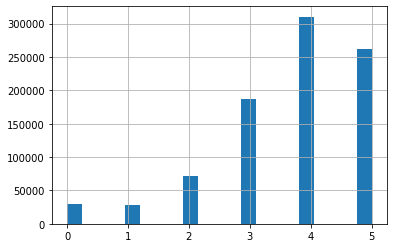

In [ ]:
# target distribution

df.rating.hist(bins = 'sturges')

In [ ]:
df.rating.value_counts(normalize = True)

4    0.348452
5    0.294292
3    0.210476
2    0.081131
0    0.033571
1    0.032078
Name: rating, dtype: float64

In [ ]:
df.rating.value_counts()

4    310207
5    261991
3    187375
2     72226
0     29886
1     28557
Name: rating, dtype: int64

negative rating (below 3 score) share is ~13%. Target is imbalanced

the minimum class #1 has enough values for training, better to balance data by under-sample to minor class



## Balance data

https://www.kaggle.com/code/mikhailutrobin/book-review-rating-with-pytorch-lightning

In [ ]:
# Let's extract a separate part from the data with balanced classes
# At the same time, it is important to keep the ratio of classes

df.sort_values(['book_id', 'rating', 'user_id'], inplace=True)
df['book_num'] = df.groupby(by=['book_id'], as_index=False, sort=False)['book_id'].transform(lambda s: np.arange(len(s))+1)
df.sort_values(['book_id', 'book_num'], inplace=True)
df['kfold'] = 0

In [ ]:
# Fill in kfold = 1 for all scores 1

df.loc[df['rating'] == 1,'kfold'] = 1

# The volume of the minimum part will determine the size of the balanced part

kfold_size = len(df[df['rating'] == 1])
kfold_size

28557

In [ ]:
# Shuffle the data and add the rest of the scores to our part

df = df.sample(frac=1)
df.sort_values(['book_num'], inplace=True)
df['rating_num'] = df.groupby(by=['rating'], as_index=False, sort=False)['rating'].transform(lambda s: np.arange(len(s))+1)
df.loc[df['rating_num'] <= kfold_size,'kfold'] = 1

In [ ]:
df.kfold.value_counts()

0    718900
1    171342
Name: kfold, dtype: int64

In [ ]:
df[df['kfold'] == 1].rating.value_counts()

1    28557
0    28557
2    28557
3    28557
4    28557
5    28557
Name: rating, dtype: int64

In [ ]:
# redefine df with only balanced data and keep history in df_all
df_all = df.copy()

df = df[df['kfold'] == 1]


## Features engineering 

In [ ]:
# add datetime features
df['reading_dur_days'] = (df['read_at'] - df['started_at']).apply(lambda x: x.days)
df['book_lifetime_days'] = (df['read_at'] - df['date_added']).apply(lambda x: x.days)
df['started_dow'] = df['started_at'].dt.dayofweek

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
# anomalies share
np.round(df[df['reading_dur_days'] < 0].shape[0] / df.shape[0], 4)

0.0

In [ ]:
df[df['book_lifetime_days'] < 0].shape[0] / df.shape[0]

0.15677417095633295

In [ ]:
np.round(df[df['n_votes'] < 0].shape[0] / df.shape[0], 4)

0.0

In [ ]:
np.round(df[df['n_comments'] < 0].shape[0] / df.shape[0], 4)

0.0

In [ ]:
# correct anomalies
df['book_lifetime_days'] = df['book_lifetime_days'].apply(lambda x: 0 if x < 0 else x)
df['reading_dur_days'] = df['reading_dur_days'].apply(lambda x: 0 if x < 0 else x)
df['n_votes'] = df['n_votes'].apply(lambda x: 0 if x < 0 else x)
df['n_comments'] = df['n_comments'].apply(lambda x: 0 if x < 0 else x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

## Visualize

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


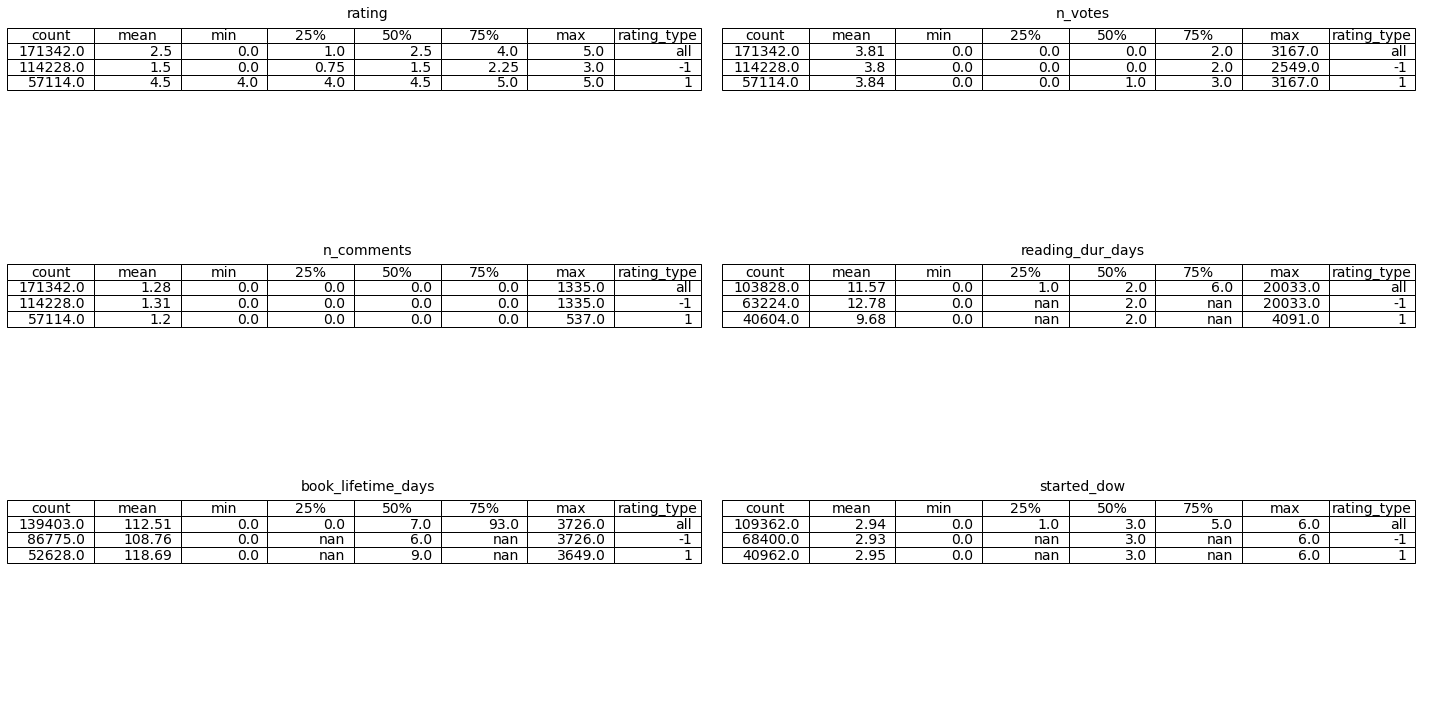

In [ ]:
numeric_cols = ['rating', 'n_votes', 'n_comments', 
             'reading_dur_days', 'book_lifetime_days', 'started_dow']

# add postive and negative target type
# 1 - positive, (-1) - negative
df['rating_type'] = df['rating'].apply(lambda x: 1 if x >= 4 else -1)

eda_df = df[numeric_cols + ['rating_type']]
 
fig, axs = plt.subplots(len(eda_df[numeric_cols].columns) // 2 , 2, figsize = (20, 10))

for ax, col in zip(axs.flatten(), eda_df[numeric_cols].columns):
    
    
    plot_df = eda_df[col].describe().to_frame().T
    
    plot_df = plot_df.drop(columns = ['std',])
    plot_df['mean'] = np.round(plot_df['mean'], 2)
    
    plot_df['rating_type'] = 'all'
    
    
    
    split_target_df = \
    (
        eda_df
        .groupby('rating_type', as_index = False)
        .agg({f'{col}': ['count', 'mean', 'min', lambda x: np.percentile(x, 25),
                                         'median',
                                           lambda x : np.percentile(x, 75),
                                           'max']})
        .reset_index()
        .rename(columns = {(f'<lambda_0>'): '25%',
                           (f'<lambda_1>'): '75%',
                           ('median'): '50%'}, level = 1)
    )
    
    split_target_df = split_target_df.drop(columns = 'index').droplevel(level = 0, axis = 1)
    
    split_target_df = split_target_df.rename(columns = {'': 'rating_type'})

    split_target_df = split_target_df.apply(pd.to_numeric, errors = 'ignore')
    
    split_target_df = split_target_df.apply(lambda x: np.round(x, 2))
    
    plot_df = pd.concat([plot_df, split_target_df])
    
    
    
    table = ax.table(cellText =plot_df.values, 
            colLabels = plot_df.columns, loc = 'best')
    
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    ax.set_title(col, fontsize = 14)
    
    ax.axis('off')
    
plt.tight_layout()
plt.show()

Numeric features density by positive and negatives reviews


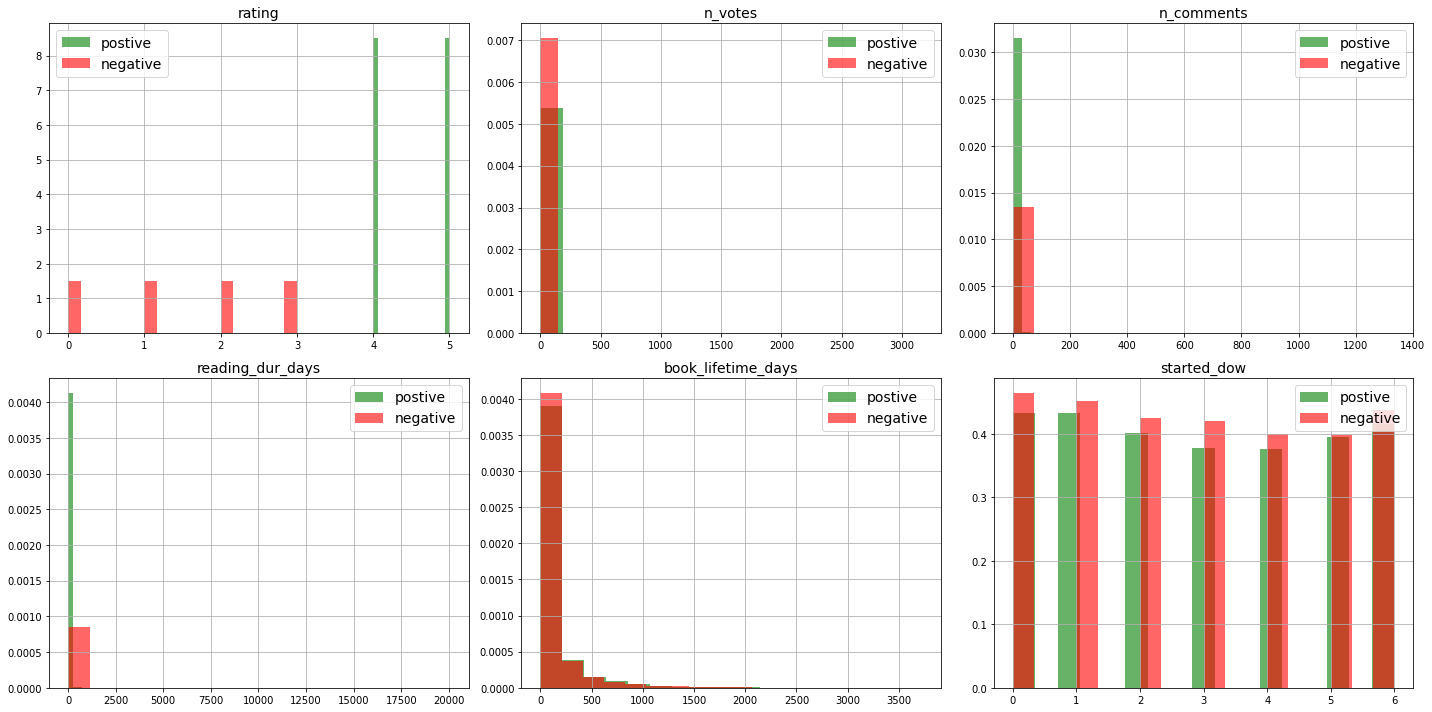

In [ ]:



fig, axs = plt.subplots(len(df[numeric_cols].columns) // 3, 3, figsize = (20, 10))

for ax, col in zip(axs.flatten(), df[numeric_cols].columns):

    
    df.query('rating >= 4')[col].hist(bins = 'sturges',
                                      density = 1,
                                      alpha = 0.6, ax = ax, 
                                      label = 'postive',
                                      color = 'g')
    
    df.query('rating < 4')[col].hist(bins = 'sturges',
                                     density = 1,
                                     alpha = 0.6, ax = ax,
                                     label = 'negative',
                                     color = 'r')
    
    ax.set_title(col, fontsize = 14)
    ax.legend(fontsize = 14)
    
print('Numeric features density by positive and negatives reviews')


plt.tight_layout()
plt.show()
    

In [ ]:
df[numeric_cols].corr(method = 'spearman').style.background_gradient(axis=None, cmap='YlOrRd')  

,rating,n_votes,n_comments,reading_dur_days,book_lifetime_days,started_dow
rating,1.000000,0.058081,-0.043111,-0.047089,0.036611,0.002990
n_votes,0.058081,1.000000,0.511506,-0.041851,0.072962,0.004381
n_comments,-0.043111,0.511506,1.000000,0.003697,0.076656,-0.002038
reading_dur_days,-0.047089,-0.041851,0.003697,1.000000,0.369066,-0.030070
book_lifetime_days,0.036611,0.072962,0.076656,0.369066,1.000000,-0.010797
started_dow,0.002990,0.004381,-0.002038,-0.030070,-0.010797,1.000000


# Insights from EDA:

- positive reviews have slightly:
  -  less votes and comments in average
  -  longer lifetime (age in store) in average
  -  shorter reading time in average

There is no information if day of week of reading start



In [ ]:
keep_cols = ['rating', 'n_votes', 'n_comments', 
             'reading_dur_days', 'book_lifetime_days',
             'review_text']

clean_df = df[keep_cols]

# Classic approach: BoW + Catboost

with BoW we get interpretable features

## Preprocessing

In [ ]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 

import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
def preprocess_text(df):
  '''
    lower case
    keep only words
    remove web links
    remove stop words, 
    lemmatize
  '''
  text = df['review_text']

  stop_words = set(stopwords.words('english')) 
  lemmatizer = WordNetLemmatizer()

  tokens = word_tokenize(text)
  remove_links = [re.sub(r'http\S+', '', text, flags=re.MULTILINE) for text in tokens]

  lemmatized = [lemmatizer.lemmatize(w.lower(), pos = 'v')
             for w in remove_links if not w in stop_words and w.isalpha()]

  result = ' '.join(lemmatized)

  return result


In [ ]:
%%time
df['preprocessed_reviews'] = df.apply(preprocess_text, axis = 1)

CPU times: user 6min 41s, sys: 4.61 s, total: 6min 45s
Wall time: 6min 45s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# inital text
df.head(1)['review_text'].values

array(['Tedious. I have no emotional investment in any of the characters. I returned it before finishing it.'],
      dtype=object)

In [ ]:
# preprocessed text
df.head(1)['preprocessed_reviews'].values

array(['tedious i emotional investment character i return finish'],
      dtype=object)

In [ ]:
# back up to csv

df.to_csv('/content/drive/MyDrive/goodreads-books-reviews-290312/goodreads_adj_balanced.csv', index=False)

## Bag of Words (BoW)

In [ ]:
# use for RAM crashes and runtime restarts
df = pd.read_csv('/content/drive/MyDrive/goodreads-books-reviews-290312/goodreads_adj_balanced.csv')

df.preprocessed_reviews = df.preprocessed_reviews.apply(lambda x: '' if x is np.nan else x)

In [ ]:
# BoW with unigram and bigrams, 1000 vector size
vectorizer = CountVectorizer(analyzer = 'word',
                             stop_words='english', 
                             max_features = 1000,
                             ngram_range = (1, 2))

In [ ]:
%%time
sparse_df = vectorizer.fit_transform(df.preprocessed_reviews)

CPU times: user 49.2 s, sys: 641 ms, total: 49.9 s
Wall time: 49.6 s


In [ ]:
%%time
dense_df = pd.DataFrame(sparse_df.toarray(),
                        columns = vectorizer.get_feature_names_out()
                        )

CPU times: user 221 ms, sys: 485 ms, total: 707 ms
Wall time: 703 ms


In [ ]:
dense_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171342 entries, 0 to 171341
Columns: 1000 entries, ability to younger
dtypes: int64(1000)
memory usage: 1.3 GB


In [ ]:
keep_cols = ['rating', 'n_votes', 'n_comments', 
             'reading_dur_days', 'book_lifetime_days',
             'review_text']

clean_df = pd.concat([df[keep_cols], dense_df], axis = 1)

In [ ]:
# target
y = clean_df['rating']
X = clean_df.drop(columns = ['rating', 'review_text'])

## Test train split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(119939, 1004) (51403, 1004) (119939,) (51403,)


## Catboost + BoW

### Grid_search, cv, train

In [ ]:
model = catboost.CatBoostClassifier( 
    loss_function='MultiClass',
    iterations=100,
    random_seed= 63,
    auto_class_weights='Balanced',
    early_stopping_rounds= 100,
    task_type='GPU')

In [ ]:
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

gs_result = model.grid_search(grid, 
                              X=X_train, 
                              y=y_train, 
                              verbose=5,
                              cv = 5)


0:	learn: 1.7805545	test: 1.7807823	best: 1.7807823 (0)	total: 25.2ms	remaining: 2.5s
1:	learn: 1.7703675	test: 1.7708015	best: 1.7708015 (1)	total: 34ms	remaining: 1.66s
2:	learn: 1.7610580	test: 1.7616782	best: 1.7616782 (2)	total: 42.5ms	remaining: 1.37s
3:	learn: 1.7526537	test: 1.7535152	best: 1.7535152 (3)	total: 50.8ms	remaining: 1.22s
4:	learn: 1.7447095	test: 1.7457503	best: 1.7457503 (4)	total: 59.4ms	remaining: 1.13s
5:	learn: 1.7373169	test: 1.7385006	best: 1.7385006 (5)	total: 68.6ms	remaining: 1.07s
6:	learn: 1.7304922	test: 1.7318281	best: 1.7318281 (6)	total: 77.6ms	remaining: 1.03s
7:	learn: 1.7243143	test: 1.7258306	best: 1.7258306 (7)	total: 85.5ms	remaining: 983ms
8:	learn: 1.7183896	test: 1.7200980	best: 1.7200980 (8)	total: 93.4ms	remaining: 944ms
9:	learn: 1.7127126	test: 1.7145419	best: 1.7145419 (9)	total: 102ms	remaining: 915ms
10:	learn: 1.7072422	test: 1.7092188	best: 1.7092188 (10)	total: 109ms	remaining: 885ms
11:	learn: 1.7023312	test: 1.7044925	best: 1.7

In [ ]:
model.get_all_params()

{'add_ridge_penalty_to_loss_function': False,
 'auto_class_weights': 'Balanced',
 'bagging_temperature': 1,
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': False,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'border_count': 128,
 'class_names': [0, 1, 2, 3, 4, 5],
 'class_weights': [1, 1, 1, 1.000050067901611, 1, 1],
 'classes_count': 0,
 'data_partition': 'DocParallel',
 'depth': 10,
 'devices': '-1',
 'eval_metric': 'MultiClass',
 'feature_border_type': 'GreedyLogSum',
 'fold_size_loss_normalization': False,
 'force_unit_auto_pair_weights': False,
 'gpu_cat_features_storage': 'GpuRam',
 'gpu_ram_part': 0.95,
 'grow_policy': 'SymmetricTree',
 'iterations': 100,
 'l2_leaf_reg': 1,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'leaf_estimation_iterations': 1,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.10000000149011612,
 'loss_function': 'MultiClass',
 'max_leaves': 1024,
 'meta_l2_exponent': 1,
 'meta_l2_

### save model

In [ ]:
# save model for crashes
fname = 'ctb_bow_balanced.cbm'
model.save_model(fname,
           format="cbm",
           export_parameters=None,
           pool=None)

### evaluate model

In [ ]:
fname = 'ctb_bow_balanced.cbm'
from catboost import CatBoostClassifier
model = CatBoostClassifier()
model = model.load_model('/content/drive/MyDrive/goodreads-books-reviews-290312/' + fname)

In [ ]:
print(classification_report(y_test, model.predict(X_test),))

              precision    recall  f1-score   support

           0       0.58      0.61      0.59      8567
           1       0.50      0.49      0.50      8567
           2       0.39      0.35      0.37      8567
           3       0.36      0.40      0.38      8568
           4       0.37      0.28      0.32      8567
           5       0.49      0.58      0.53      8567

    accuracy                           0.45     51403
   macro avg       0.45      0.45      0.45     51403
weighted avg       0.45      0.45      0.45     51403



Text(0.5, 1.0, 'top 30 Feature Importance')

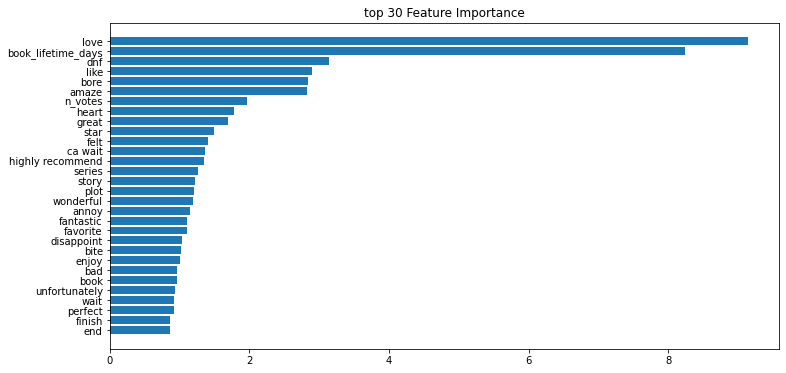

In [ ]:

feature_importance = model.get_feature_importance()
sorted_idx = np.argsort(feature_importance)[::-1][:30][::-1]
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('top 30 Feature Importance')


F-1 score is bad, 0.45

Feature importance looks reasonable.

### test data

In [ ]:
submit_df = test_df[['review_id', 'review_text']]

In [ ]:
%%time
submit_df['preprocessed_reviews'] = submit_df.apply(preprocess_text, axis = 1)

CPU times: user 18min 27s, sys: 13.7 s, total: 18min 41s
Wall time: 18min 37s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# BoW with unigram and bigrams, 1000 vector size
vectorizer = CountVectorizer(analyzer = 'word',
                             stop_words='english', 
                             max_features = 1000,
                             ngram_range = (1, 2))

sparse_submit_df = vectorizer.fit_transform(submit_df.preprocessed_reviews)

In [ ]:
submit_df['rating'] = model.predict(sparse_submit_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# the most reviews are bad - different distribution to training data
submit_df.rating.value_counts(normalize = True)

3    0.403667
1    0.195694
2    0.181105
0    0.086645
4    0.081329
5    0.051561
Name: rating, dtype: float64

In [ ]:
submit_df.sample(1).T

,472850
review_id,832aced778f33363442fe86b281ffc30
review_text,"A very early, very different Christie. Laugh-o..."
preprocessed_reviews,a early different christie loud funny time qui...
rating,0


In [ ]:
# predicted rating is zero, but actual text review looks like 4 or 5 rating
test_df[test_df['review_id'] == "832aced778f33363442fe86b281ffc30"].review_text.values

array(["A very early, very different Christie. Laugh-out loud funny at times, with quick pacing and an ending I didn't see coming!"],
      dtype=object)

In [ ]:
test_df[test_df['review_text'].str.contains('love')].sample(1)[['review_id', 'review_text']].review_text.values

array(['**MINI review originally posted on Paper Addictions & Magic** \n *Actually 3.5* \n This book was so funny! Humor right in the first chapter when Austin is fighting to stay straight while he is, at that moment, hugely attracted to a boy in bunny slippers. I loved Austin\'s infatuation with the bunny slippers, a perfect nickname for the sassy Peter. This was an entertaining light read I partook of recently. I thoroughly enjoyed the banter between all the characters, especially Austin and Bunny Slippers, and I thought Peter\'s brother was adorable. (There\'s actually a separate book about his own romance. *waggles eyebrows*) \n And I say it was a light read because, though it is 360 pages, there wasn\'t too much going on. The romance took up most of the book with the crime aspect of it kind of shoved back. It was a crazy mess of drugs, prostitutes, and money! I think it was hard to follow sometimes? I\'m not sure because I read it earlier this year before deciding to start reviewi

In [ ]:
# the rating looks like 5 star review but predicted rating is 0
submit_df[submit_df['review_id'] == "c631bf21a200f49c022e0e54df16973a"]

,review_id,review_text,preprocessed_reviews,rating
473262,c631bf21a200f49c022e0e54df16973a,Meh. I love Fitz and the Fool but this story d...,meh i love fitz fool story real drive behind a...,0


In [ ]:
submit_df[['review_id', 'rating']].to_csv('/content/drive/MyDrive/goodreads-books-reviews-290312/balanced_submission.csv', index=False)

## Conclusion



*   Bow + CatBoost has poor quality of prediction - evaluation metric F1 on test_df is 0.16127 (Your most recent submission scored 0.16127)

*   Next step is try BERT



# Bert base

In [ ]:
# use for RAM crashes and runtime restarts
df = pd.read_csv('/content/drive/MyDrive/goodreads-books-reviews-290312/goodreads_adj_balanced.csv')

In [ ]:
# https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

In [ ]:
 # pip install transformers

In [ ]:
# upper limit of n sentences in text is 42
np.percentile(df['review_text'].apply(lambda x: len(x.split('.'))), 95)

42.0

In [ ]:
def count_words(df):
  text = df.review_text
  sequences = text.split('.')
  list_of_lengthes = list(map(len, list(map(lambda x: x.split(), sequences))))
  return np.mean(list_of_lengthes)

df['n_words'] = df.apply(count_words, axis = 1)

# upper limit of n words in sentence is 25
np.percentile(df['n_words'], 95)

24.153729603729563

In [ ]:
# keep only text and target class
bert_df = df[['rating', 'review_text']]

In [ ]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = df.rating.tolist()
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 25, truncation=True,
                                return_tensors="pt") for text in df['review_text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
np.random.seed(11)
df_train, df_val, df_test = np.split(bert_df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))


137073 17134 17135


In [ ]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 6)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, 
                                     attention_mask=mask,
                                     return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
from torch.optim import AdamW
from tqdm import tqdm
               
import torch
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')


train, val = Dataset(df_train), Dataset(df_val)

train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


KeyboardInterrupt: ignored

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):

    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')

In [ ]:
EPOCHS = 3
LR = 1e-5

model = BertClassifier()
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


cuda


100%|██████████| 68537/68537 [1:16:55<00:00, 14.85it/s]


Epochs: 1 | Train Loss:  0.690                 | Train Accuracy:  0.430                 | Val Loss:  0.651                 | Val Accuracy:  0.466


100%|██████████| 68537/68537 [1:17:02<00:00, 14.83it/s]


Epochs: 2 | Train Loss:  0.571                 | Train Accuracy:  0.537                 | Val Loss:  0.646                 | Val Accuracy:  0.474


100%|██████████| 68537/68537 [1:15:54<00:00, 15.05it/s]


Epochs: 3 | Train Loss:  0.410                 | Train Accuracy:  0.677                 | Val Loss:  0.730                 | Val Accuracy:  0.466


In [ ]:
SAVE_PATH = '/content/drive/MyDrive/goodreads-books-reviews-290312/bert_cased.pt'
torch.save(model.state_dict(), SAVE_PATH)

## Accuracy, eval

In [ ]:
model = BertClassifier()
model.load_state_dict(torch.load('/content/drive/MyDrive/goodreads-books-reviews-290312/bert_cased.pt'))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:

def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)

Test Accuracy:  0.469


## Submission

In [ ]:
bert_submit_df = test_df[['review_id', 'review_text']]

In [ ]:
class SubmissionDataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 25, truncation=True,
                                return_tensors="pt") for text in df['review_text']]


    def __len__(self):
        return len(self.texts)

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)

        return batch_texts


submission_dataset= SubmissionDataset(bert_submit_df)

submission_dataloader = torch.utils.data.DataLoader(submission_dataset, batch_size=2)


  

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

predictions = []
if use_cuda:

    model = model.cuda()

with torch.no_grad():

    for test_input in submission_dataloader:

      mask = test_input['attention_mask'].to(device)
      input_id = test_input['input_ids'].squeeze(1).to(device)

      output = model(input_id, mask)

      prediction = output.argmax(dim=1).to('cpu')

      predictions.append(prediction)

In [ ]:
# unpack batch predictions to flat list 
flat_predictions = []
for preds in predictions:

  for p in preds.numpy():
    flat_predictions.append(p)

bert_submit_df['rating'] = pd.Series(flat_predictions)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
bert_submit_df.rating.isna().sum()

0

In [ ]:
# the rating looks like 5 star review but predicted rating is 2
bert_submit_df[bert_submit_df['review_id'] == "c631bf21a200f49c022e0e54df16973a"]

,review_id,review_text,rating
473262,c631bf21a200f49c022e0e54df16973a,Meh. I love Fitz and the Fool but this story d...,2


In [ ]:
# the rating looks like 3.5 star review but predicted rating is 3
bert_submit_df[bert_submit_df['review_id'] == "9410baca1b66bb759fb5095933055ba7"]

,review_id,review_text,rating
391501,9410baca1b66bb759fb5095933055ba7,"3.5 stars from me. It was a cute, short read. ...",3


In [ ]:
bert_submit_df[['review_id', 'rating']].to_csv('/content/drive/MyDrive/goodreads-books-reviews-290312/bert_submission.csv', index=False)

In [ ]:
SAVE_PATH = '/content/drive/MyDrive/goodreads-books-reviews-290312/bert_cased_cpu.pt'
torch.save(model.to('cpu').state_dict(), SAVE_PATH)

Your most recent submission scored 0.43201